In [32]:
import os
import sys
from pathlib import Path
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from skimage.measure import regionprops_table
from skimage import exposure, measure
import dask.dataframe as dd
import dask_ml.cluster
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.cluster.hierarchy as sch
import matplotlib
import seaborn as sns
from collections import defaultdict


In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [35]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [36]:
# Define image and masks folder
info_csv = data_meta / "info_combined.csv"

df = pd.read_csv(info_csv)

In [37]:
df = df[df.After_bleach==False]

# Get pixel one fov

In [38]:
def get_location(df, location):
    imgs_path = []
    markers = []
    df = df[(df.Location == location)]
    for row in df.itertuples():
        imgs_path.append(row.Path)
        markers.append(row.Marker)
    return imgs_path, markers

def combined_imgs(imgs: List[str]) -> np.ndarray:
    """
    Return an multiplex image of dimension (num markers, height,width)
    """
    if not imgs:
        raise Exception("You passed a empty list of images path")
    pixels = []
    for img_path in imgs:
        img = skimage.io.imread(img_path)
        img = img[:1000, :1000]
        p2, p98 = np.percentile(img, (0, 99.9))
        img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0,1))
        pixels.append(img)
    return np.stack(pixels)

def non_border_cell(cell_mask):
    labels = []
    row_max, col_max = cell_mask.shape
    props = measure.regionprops(cell_mask)
    for prop in props:
        if prop['bbox'][0] == 0 or prop['bbox'][1] == 0 or prop['bbox'][2] == row_max or prop['bbox'][3] == col_max:
            continue
        else:
            labels.append(prop['label'])
    return labels

def get_multiplex_pix(df, masks):
    df_appended = []
    for idx, location in enumerate(masks.keys()):
        # Get pixels data
        imgs, markers = get_location(df, int(location))
        pixels = combined_imgs(imgs)
        
        # Get cell and nuclei mask
        mask_cyto = masks[location]["cyto"][:1000,:1000]
        mask_nuclei = masks[location]["nuclei"][:1000,:1000]
        cell, _, _ = my_utils.qc_nuclei(mask_cyto, mask_nuclei)
        
        labels = non_border_cell(cell)
        
        # Extracted all multiplex pixels in cell
        rows, cols = np.where(np.isin(cell, labels))
        cell_pixels = pixels[:, rows, cols]

        # Create dataframe
        df_pixels = pd.DataFrame(cell_pixels.T, columns=markers)
        df_pixels["Location"] = location
        df_pixels["X"] = rows
        df_pixels["Y"] = cols
        df_pixels["Id"] = cell[rows, cols]
        df_dapi = df_pixels.filter(like="Hoeschst")
        df_pixels = df_pixels.drop(df_dapi, axis=1)
        df_pixels.insert(
            0, column="Hoeschst", value=df_dapi.mean(axis=1).astype(np.uint16)
        )
        df_appended.append(df_pixels)

    df_pixels = pd.concat(df_appended, ignore_index=True)

    return df_pixels

In [39]:
masks = my_utils.get_masks(data_mask)

In [40]:
masks_1 = {'1': masks['1']}

In [41]:
df_pixels = get_multiplex_pix(df, masks_1)

In [42]:
pixels = df_pixels.iloc[:, :-4]
pixels = pixels.drop(columns=['Concanavalin A', 'Phalloidin', 'Hoeschst', 'WGA', 'B-actin', 'PCNA'])

pixels.head()

,p-EGFR,APC,DKK1,Non-p-B-catenin,Cyclin E,EMMPRIN,Wnt1,RNF 43,p-AKT,p-B-catenin,...,mTOR,p-mTOR,AXIN1,DKK2,EGFR,B-tubin,Cyclin D1,H3k27me3-488,H3k4me3-647,H3k9Ac-555
0,0.000000,0.083768,0.042553,0.0,0.000000,0.041376,0.000000,0.158133,0.024058,0.293490,...,0.075362,0.250533,0.000000,0.101215,0.286064,0.077,0.086817,0.0,0.053571,0.045408
1,0.000000,0.000000,0.075569,0.0,0.020809,0.057354,0.087165,0.146084,0.000000,0.035219,...,0.410145,0.207889,0.043172,0.000000,0.374083,0.021,0.059486,0.0,0.012458,0.160991
2,0.000000,0.000000,0.173881,0.0,0.000000,0.004506,0.000000,0.228916,0.036314,0.052295,...,0.133333,0.216418,0.000000,0.000000,0.283619,0.164,0.000000,0.0,0.009136,0.125387
3,0.000000,0.004007,0.110051,0.0,0.002956,0.086440,0.052203,0.174699,0.000000,0.081110,...,0.342029,0.351812,0.101322,0.000000,0.183374,0.103,0.105305,0.0,0.022425,0.000516
4,0.023359,0.000000,0.051357,0.0,0.000000,0.038509,0.023946,0.201807,0.000000,0.195304,...,0.060870,0.215352,0.029956,0.000000,0.422983,0.142,0.099678,0.0,0.024086,0.061404


In [43]:
# Parameters
min_intensity = 0.3
random_seed = 1

In [44]:
pixel_dark = pixels.le(min_intensity).all(axis=1)
display(pixel_dark.value_counts())
pixels_bright = pixels[~pixel_dark]
display(pixels_bright.head())

False    314509
True      52561
dtype: int64

,p-EGFR,APC,DKK1,Non-p-B-catenin,Cyclin E,EMMPRIN,Wnt1,RNF 43,p-AKT,p-B-catenin,...,mTOR,p-mTOR,AXIN1,DKK2,EGFR,B-tubin,Cyclin D1,H3k27me3-488,H3k4me3-647,H3k9Ac-555
1,0.000000,0.000000,0.075569,0.000000,0.020809,0.057354,0.087165,0.146084,0.000000,0.035219,...,0.410145,0.207889,0.043172,0.000000,0.374083,0.021,0.059486,0.0,0.012458,0.160991
3,0.000000,0.004007,0.110051,0.000000,0.002956,0.086440,0.052203,0.174699,0.000000,0.081110,...,0.342029,0.351812,0.101322,0.000000,0.183374,0.103,0.105305,0.0,0.022425,0.000516
4,0.023359,0.000000,0.051357,0.000000,0.000000,0.038509,0.023946,0.201807,0.000000,0.195304,...,0.060870,0.215352,0.029956,0.000000,0.422983,0.142,0.099678,0.0,0.024086,0.061404
5,0.000000,0.000000,0.096845,0.073227,0.000000,0.012290,0.033525,0.216867,0.024512,0.045891,...,0.085507,0.300640,0.098678,0.284750,0.202934,0.106,0.015273,0.0,0.016196,0.019608
7,0.000000,0.000000,0.112986,0.023799,0.000000,0.050799,0.065613,0.000000,0.000000,0.176094,...,0.143478,0.163113,0.108370,0.336032,0.161369,0.280,0.081994,0.0,0.016196,0.091331


# K-Means clustering

In [88]:
X = dd.from_pandas(pixels_bright, chunksize=100000)

In [89]:
X = X.persist()
X

,p-EGFR,APC,DKK1,Non-p-B-catenin,Cyclin E,EMMPRIN,Wnt1,RNF 43,p-AKT,p-B-catenin,AKT,mTOR,p-mTOR,AXIN1,DKK2,EGFR,B-tubin,Cyclin D1,H3k27me3-488,H3k4me3-647,H3k9Ac-555
npartitions=4,,,,,,,,,,,,,,,,,,,,,
1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
119948,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232063,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350179,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367069,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [90]:
km = dask_ml.cluster.KMeans(n_clusters=25)
km.fit(X)

Found fewer than 25 clusters in init (found 19).


KMeans(n_clusters=25)

In [91]:
labels = km.labels_

In [92]:
labels = labels.compute()

In [93]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(pixels_bright)
pixels_bright_position = pd.DataFrame(x_scaled, columns=pixels_bright.columns, index=pixels_bright.index)

In [94]:
pixels_bright_position["label"] = labels
# Get dataframe per cluster
df_per_label = pixels_bright_position.groupby("label").mean()
df_per_label.head()

,p-EGFR,APC,DKK1,Non-p-B-catenin,Cyclin E,EMMPRIN,Wnt1,RNF 43,p-AKT,p-B-catenin,...,mTOR,p-mTOR,AXIN1,DKK2,EGFR,B-tubin,Cyclin D1,H3k27me3-488,H3k4me3-647,H3k9Ac-555
label,,,,,,,,,,,,,,,,,,,,,
0,-0.373002,-0.069578,-0.115812,-0.421220,-0.247852,-0.115857,0.012122,0.088493,-0.336438,-0.389173,...,1.946728,-0.252107,-0.269618,-0.469682,-0.304530,0.014116,-0.149085,-0.417635,-0.359361,-0.392233
1,0.393963,0.474162,0.845279,0.031435,0.951813,1.370372,1.297012,0.981153,0.639940,0.129053,...,0.552837,0.214530,0.305777,0.017115,0.775649,0.550415,0.682635,-0.225532,-0.311807,-0.134407
2,-0.523017,-0.221709,-0.329225,-0.521508,-0.323302,-0.290518,-0.284858,-0.223926,-0.470082,-0.505456,...,-0.321443,1.281031,-0.339763,-0.563780,-0.510562,-0.122238,-0.260066,-0.459236,-0.382534,-0.434020
3,1.279769,-0.218707,0.006598,1.324967,0.498796,-0.029053,-0.385262,-0.338595,0.985797,0.102684,...,0.008529,-0.028722,0.157265,1.147316,-0.468704,-0.151819,0.464030,1.175370,1.084529,1.007384
4,-0.528334,-0.253144,-0.320028,-0.527884,-0.321539,-0.291066,-0.291668,-0.123968,-0.457731,0.456269,...,-0.334889,-0.544056,-0.367968,-0.637669,0.428147,-0.086301,-0.209984,-0.464478,-0.376575,-0.427368


In [113]:
my_cmap = "bwr"
scale_name = "Z-score"



In [114]:
def create_HM(
    df_per_label, my_cmap, row_colors, scale_name, cellSizePixels=20, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        col_cluster=False,
        row_colors=[row_colors],
        dendrogram_ratio=(0.1, 0.0),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Cluster")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_row_orig_pos = ax.ax_row_colors.get_position()
    ax.ax_row_colors.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1.05, pos.y0, .03, cbar_size))

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)


def create_umap(embeddings, labels, cmap, name = 'Umap'):
    fig, ax = plt.subplots(figsize=(10, 10))
    X, Y = embeddings[:, 0], embeddings[:, 1]
    ax.scatter(X, Y, c=labels, s=2, cmap=matplotlib.colors.ListedColormap(cmap))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Add arrow with spine
    pos = ax.get_position()
    ax.plot(pos.x1, pos.y0, ">k", transform=fig.transFigure, clip_on=False)
    ax.plot(pos.x0, pos.y1, "^k", transform=fig.transFigure, clip_on=False)

    # Add label
    ax.set_xlabel(f'{name} 1')
    ax.set_ylabel(f'{name} 2')

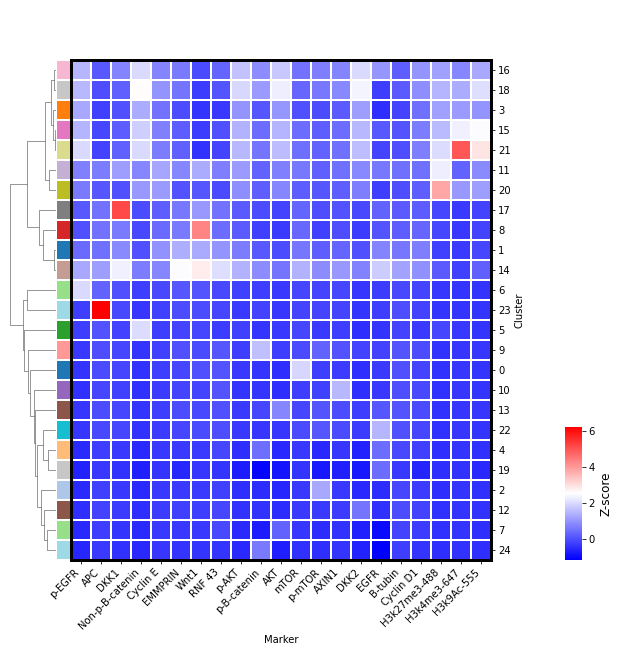

In [115]:
# Get linkage
d = sch.distance.pdist(df_per_label, metric='cosine')
L = sch.linkage(d, method="average")

# Get colormap
vals = np.linspace(0, 1, len(df_per_label))
my_cmap_row = plt.cm.tab20(vals)

# Clustermap and umap
labels = df_per_label.index.to_list()
my_cmap_dict = dict(zip(labels, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)
create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)
# create_umap(embeddings, parc_labels, my_cmap_row)

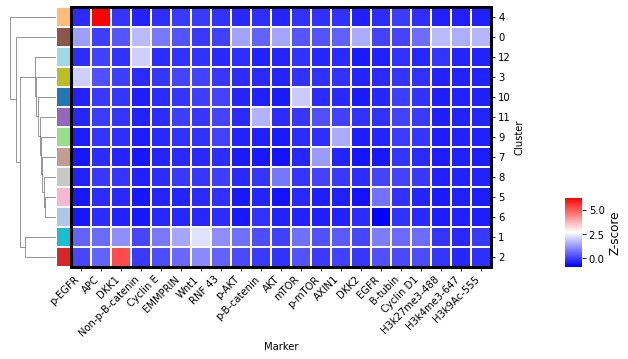

In [116]:
tol = 0.22

# Merge similar cluster
clusters = sch.fcluster(L, tol * d.max(), "distance") - 1
clusters_unique = np.unique(clusters)
n_clusters = len(np.unique(clusters))

# Clustermap and umap
label2cluster = dict(zip(labels, clusters))
result = defaultdict(int)
for k, v in zip(clusters, labels):
    result[k] = max(result[k], v)
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(result).map(my_cmap_dict)
clusters = np.array(list(map(label2cluster.get, labels)))
new_parc_labels = np.array(list(map(result.get, clusters)))
# create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

# Clustermap and umap with new colormap
vals = np.linspace(0, 1, n_clusters)
np.random.seed(0)
np.random.shuffle(vals)
my_cmap_row = plt.cm.tab20(vals)
my_cmap_dict = dict(zip(clusters_unique, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(label2cluster).map(my_cmap_dict)
new_parc_labels = np.array(list(map(label2cluster.get, labels)))
# create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)

# Combined 
df_combined = pixels_bright_position.copy()
df_combined.label = df_combined.label.map(label2cluster.get)
df_combined = df_combined.groupby("label").mean()
labels = df_combined.index.to_list()

row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)

create_HM(df_combined, my_cmap, row_colors, scale_name)


In [117]:
labels = km.labels_
labels = labels.compute()
labels = [*map(label2cluster.get, labels)]

# DBSCAN clustering

In [56]:
pixels_bright.values.shape

(314509, 21)

In [57]:
import hdbscan

clustering_dbscan = hdbscan.HDBSCAN().fit(pixels_bright.values)

In [58]:
pixels_bright_position["label"] = clustering_dbscan.labels_
# Get dataframe per cluster
df_per_label = pixels_bright_position.groupby("label").mean()
df_per_label.head()

,p-EGFR,APC,DKK1,Non-p-B-catenin,Cyclin E,EMMPRIN,Wnt1,RNF 43,p-AKT,p-B-catenin,...,mTOR,p-mTOR,AXIN1,DKK2,EGFR,B-tubin,Cyclin D1,H3k27me3-488,H3k4me3-647,H3k9Ac-555
label,,,,,,,,,,,,,,,,,,,,,
-1,1.022515,0.621360,0.979635,0.919421,0.969848,0.879653,1.034455,0.565004,1.029999,0.422916,...,0.624421,0.331801,0.512762,0.756735,0.428262,0.433708,0.653437,1.088251,0.703058,0.838431
0,-0.528082,0.310930,-1.045219,-0.599625,-0.244592,7.887237,8.062196,-0.249765,-0.583971,-0.116227,...,0.219244,-0.399665,-0.976196,-0.520483,0.091838,0.141421,-0.104956,-0.487202,-0.298152,-0.489179
1,1.068475,0.578914,1.238413,0.236668,1.074131,1.260366,4.914437,2.369189,3.610251,0.770494,...,1.736143,1.427915,0.520929,0.194794,3.450169,8.677870,0.801809,-0.036523,-0.281594,1.024852
2,1.300046,-0.518092,0.219477,1.501792,13.384745,-0.346621,-0.823013,-1.033321,1.160681,-0.141709,...,-0.607162,-0.630845,-0.729593,0.737871,-0.347281,-0.503013,0.350664,0.928384,1.319886,1.520057
3,0.369151,0.121772,0.415030,0.673453,1.199223,-0.129982,0.452823,0.808150,0.828681,-0.308635,...,6.919068,-0.080489,0.075077,0.452325,-0.142621,-0.215776,0.268989,3.597421,0.768518,0.843731


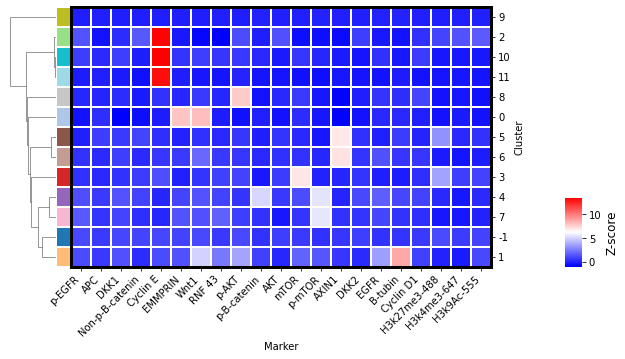

In [59]:
# Get linkage
d = sch.distance.pdist(df_per_label, metric='cosine')
L = sch.linkage(d, method="average")

# Get colormap
vals = np.linspace(0, 1, len(df_per_label))
my_cmap_row = plt.cm.tab20(vals)

# Clustermap and umap
labels = df_per_label.index.to_list()
my_cmap_dict = dict(zip(labels, my_cmap_row))
row_colors = pd.DataFrame(labels)[0].map(my_cmap_dict)
create_HM(df_per_label, my_cmap, row_colors, scale_name, row_linkage=L)
# create_umap(embeddings, parc_labels, my_cmap_row)

# Clustering metric

In [104]:
from sklearn import metrics
n = 50

In [132]:
metrics.silhouette_score(pixels_bright.values[::n,:], clustering_dbscan.labels_[::n], metric='cosine')

0.15961959771755616

In [133]:
metrics.silhouette_score(pixels_bright.values[::n,:], labels[::n], metric='cosine')

0.09293371909197587

In [134]:
random_labels = np.random.randint(low=0, high=13, size=len(labels))

In [135]:
metrics.silhouette_score(pixels_bright.values[::n,:], random_labels[::n], metric='cosine')

-0.03133863795536993

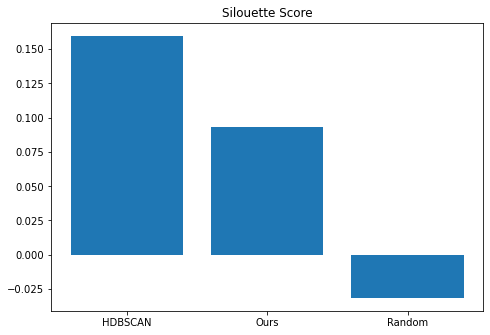

In [137]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['HDBSCAN', 'Ours', 'Random']
students = [0.15961, 0.092933,-0.0313386]
ax.bar(langs,students)
ax.set_title('Silouette Score')
plt.show()